# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-polarizadores-lineales" data-toc-modified-id="Determinación-de-los-parámetros-de-los-polarizadores-lineales-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los polarizadores lineales</a></div><div class="lev2 toc-item"><a href="#Cargar-la-intensidad-con-P1-y-P4" data-toc-modified-id="Cargar-la-intensidad-con-P1-y-P4-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cargar la intensidad con P1 y P4</a></div><div class="lev2 toc-item"><a href="#Resultados" data-toc-modified-id="Resultados-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Resultados</a></div>

# Determinación de los parámetros de los polarizadores lineales

**Autor**: Luis Miguel Sanchez Brea

**Fecha**:   21/03/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm (corriente = 314 mA).
1. Lente colimadora de Thorlabs DG10-600-B.
1. Difusor.
1. Lámina retardadora $\lambda/4$ ... de Throlabs para hacer el haz de luz circular.
1. Polarizador 1
1. Polarizador 4

**Procedimiento**:

Una vez conocido el angulo de P1, se pone horizontal a la superficie. 

1. Se gira el polarizador P4 una vuelta.


**Resultado**

1. Posición del ángulo de P4 respecto a P1
1. Parámetros de P1 a partir del valor máximo y mínimo de intensidad


El ángulo de P1 donde haya máxima intensidad es aquel alineado con el suelo.

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from __future__ import print_function

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import pprint

np.set_printoptions(precision=4)
sp.set_printoptions(precision=4)

from phyton_optics import degrees 

from scipy import optimize
from polarimeter.utils import plot_experiment_residuals_1D
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller

from scipy.io import loadmat

## Cargar la intensidad con P1 y P4

El máximo de intensidad alinea el eje P4 con P1.

El motor 1 esta en 0 grados, por lo que el eje del polarizador esta a 6.6962 º

Se mueve el motor 4.

La posición de máximo los dos polarizadores lineales están alineados

(0, 1.4760375721147285)

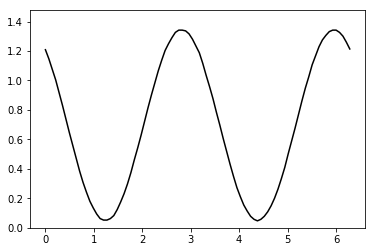

In [8]:
data_2=np.load('step4_parametros_P4_absolute_2018-03-21.npy')
#angles_2 esta en 0-360 hay que pasar de 0 a 2pi
angles_2=data_2[:,0]*degrees
intensities_2=data_2[:,1]

plt.figure()
plt.plot(angles_2,intensities_2,'k')
plt.ylim(0,intensities_2.max()*1.1)

## Fitting data to sine

Fit examples with sinusoidal functions

In [9]:
#Fitting parameters 
# Fit the first set
sin_func = lambda par, x: par[0]+par[1]*np.cos(2*np.pi/par[2]*(x-par[3])) # Target function
errfunc = lambda par, x, y: sin_func(par, x) - y # Distance to the target function

0.697856468881 0.646972206448 180.036247427 161.096675951


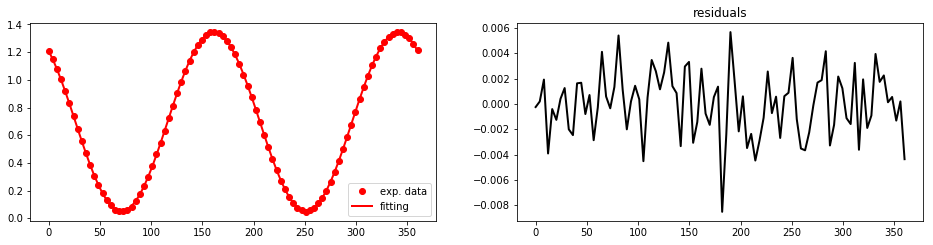

In [12]:
par0 = [1.25,2.5, sp.pi, 0.] # Initial guess for the parameters
par1, success = optimize.leastsq(errfunc, par0[:], args=(angles_2, intensities_2))
if par1[3]<0:
    par1[3]=par1[3]+sp.pi

print (par1[0], par1[1], par1[2]/degrees, par1[3]/degrees)

I_fitting=sin_func(par1, angles_2)
residuals=intensities_2-I_fitting

plot_experiment_residuals_1D(angles_2, intensities_2, I_fitting,  title='')

## Calibration parameters

In [13]:
Imin=par1[0]-par1[1]
Imax=par1[0]+par1[1]
I0 = 3.1049
angle4_max=par1[3]

if Imin>Imax:
    Imin,Imax=Imax,Imin

print("I0        = {:4.4} V".format(I0))
print("Imin      = {:4.4} V".format(Imin))
print("Imax      = {:4.4} V".format(Imax))
print("angle_max = {:4.5} º".format(angle4_max/degrees))

p0=((Imax+sp.sqrt(Imax**2-Imin**2))/I0)**(0.25)
p1=sp.sqrt(Imin/sp.sqrt(I0*(Imax+sp.sqrt(Imax**2-Imin**2))))

if p0>p1:
    p0,p1=p1,p0
print("Polarizer, parameters p0={}, p1={}".format(p0, p1))

I0        = 3.105 V
Imin      = 0.05088 V
Imax      = 1.345 V
angle_max = 161.1 º
Polarizer, parameters p0=0.132707197792, p1=0.964658186799


## Fitting to matrices - 1: sencillo
Aquí hacemos el ajuste solo al ángulo, asumiendo los valores de los polarizadores que vienen calculados y la luz, también calculada

In [14]:
[amplitude, angle, phase], u0= get_light_parameters()
print(u0)

[[ 3.5431]
 [-0.0246]
 [ 0.0126]
 [ 3.5429]]


In [15]:
pol_dicts =get_polarimeter_parameters(kind='exp')
pol1,pol2,pol3,pol4 = pol_dicts

pol1 = dict(theta_axis=0, p0=p0, p1=p1)
pol4 = dict(theta_axis=0, p0=p0, p1=p1)

P1_0,P2_0,P3_0,P4_0=polarimeter_matrices(pol_dicts, angles=[0,0,0,0])
pprint.pprint(P1_0)

P1,P2,P3,P4=polarimeter_matrices(pol_dicts, angles=None)
pprint.pprint(P1)


matrix([[ 0.4741,  0.4565,  0.    ,  0.    ],
        [ 0.4565,  0.4741,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.128 ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.128 ]])
matrix([[ 0.4741,  0.4543,  0.0444,  0.    ],
        [ 0.4543,  0.4708,  0.0335,  0.    ],
        [ 0.0444,  0.0335,  0.1313,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.128 ]])


In [16]:
def get_intensity_numerical(par_fitting, angles, u0):
    """
    par_fitting es el ángulo del polarizador 4
    """
    angle_4=par_fitting

    P1_r = P1
    P4=rotate_mueller(P4_0, angle_4)
    
    intensity_numerical=sp.zeros_like(angles,dtype=float)
    for i, angle in enumerate(angles):
        P4_r =rotate_mueller(P4, angle)
        intensity_numerical[i]=intensity(P4_r*P1_r*u0)
    
    return intensity_numerical

In [17]:
errfunc2 = lambda par, x, u0, y: abs(get_intensity_numerical(par, x, u0) - y).sum()
# Distance to the target function

In [18]:
params_1_ini = np.array([158*degrees]) # Initial guess for the parameters
params_1_fin, success = optimize.leastsq(errfunc2, params_1_ini, 
                                         args=(angles_2, u0, intensities_2))
print(params_1_fin/degrees)

[ 202.9275]


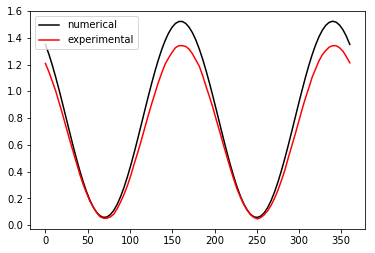

In [19]:
intensity_numerical=get_intensity_numerical(params_1_fin, angles_2, u0)
plt.figure()
plt.plot(angles_2/degrees, intensity_numerical,'k',label='numerical')
plt.plot(angles_2/degrees, intensities_2,'r', label='experimental')
plt.legend()

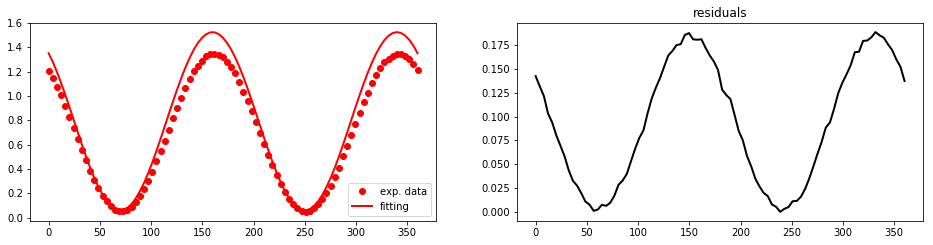

202.927531683
std_residuals 1=0.0644309613871, = 4.80164318746 %


In [20]:
I_fitting=get_intensity_numerical(params_1_fin,angles_2, u0)
plot_experiment_residuals_1D(angles_2, intensities_2, I_fitting)

print(params_1_fin[0]/degrees)
residuals1=(I_fitting-intensities_2)
print("std_residuals 1={}, = {} %".format(sp.std(residuals1),
                                          sp.std(residuals1)/intensities_2.max()*100))

## Fitting to matrices - 2: completo
Aquí hacemos el ajuste al ángulo, y p0,p1 de los polarizadores

In [23]:
pol_dicts =get_polarimeter_parameters(kind='exp')
pol1,pol2,pol3, pol4 = pol_dicts
p0=pol1['p0']
p1=pol1['p1']
theta=pol1['theta_axis']
print(pol1)
print(pol1['theta_axis']/degrees)

{'p0': 0.132707197792, 'p1': 0.964658186799, 'theta_axis': 0.048659779545601904}
2.788


In [24]:
P1=polarizer_linear(p1=p1, p2=p0, theta=0)
print(P1)
print("Realmente estamos rotados unos grados {}".format(theta/degrees))

[[ 0.4741  0.4565  0.      0.    ]
 [ 0.4565  0.4741  0.      0.    ]
 [ 0.      0.      0.128   0.    ]
 [ 0.      0.      0.      0.128 ]]
Realmente estamos rotados unos grados 2.788


In [25]:
P1_r=    rotate_mueller(P1, theta)
print(P1_r)
P1_r=    rotate_mueller(P1, -theta)
print(P1_r)
P1b=rotate_mueller(P1_r, theta)
print(P1b)
print(angles_2)

[[ 0.4741  0.4543  0.0444  0.    ]
 [ 0.4543  0.4708  0.0335  0.    ]
 [ 0.0444  0.0335  0.1313  0.    ]
 [ 0.      0.      0.      0.128 ]]
[[ 0.4741  0.4543 -0.0444  0.    ]
 [ 0.4543  0.4708 -0.0335  0.    ]
 [-0.0444 -0.0335  0.1313  0.    ]
 [ 0.      0.      0.      0.128 ]]
[[ 0.4741  0.4565 -0.      0.    ]
 [ 0.4565  0.4741  0.      0.    ]
 [-0.      0.      0.128   0.    ]
 [ 0.      0.      0.      0.128 ]]
[ 0.      0.0706  0.1412  0.2118  0.2824  0.353   0.4236  0.4942  0.5648
  0.6354  0.706   0.7766  0.8472  0.9178  0.9884  1.059   1.1296  1.2002
  1.2708  1.3414  1.412   1.4825  1.5531  1.6237  1.6943  1.7649  1.8355
  1.9061  1.9767  2.0473  2.1179  2.1885  2.2591  2.3297  2.4003  2.4709
  2.5415  2.6121  2.6827  2.7533  2.8239  2.8945  2.9651  3.0357  3.1063
  3.1769  3.2475  3.3181  3.3887  3.4593  3.5299  3.6005  3.6711  3.7417
  3.8123  3.8829  3.9535  4.0241  4.0947  4.1653  4.2359  4.3065  4.3771
  4.4476  4.5182  4.5888  4.6594  4.73    4.8006  4.8712  4.9418  

In [26]:
def get_intensity_numerical_all(par_fitting, angles, u0):
    """
    par_fitting es el ángulo del polarizador 4"""
    
    angle_4, p1, p0=par_fitting
    
    P1=polarizer_linear(p1=p1, p2=p0, theta=0)
    P4=polarizer_linear(p1=p1, p2=p0, theta=0)
    
    P1_r = rotate_mueller(P1, 6.6962 * degrees)
    P4=rotate_mueller(P4, angle_4) 
    
    intensity_numerical=sp.zeros_like(angles,dtype=float)
    for i, angle in enumerate(angles):
        P4_r =rotate_mueller(P4, angle)
        intensity_numerical[i]=intensity(P4_r*P1_r*u0)
    
    return intensity_numerical

In [27]:
errfunc3 = lambda par, x, u0, y: abs(get_intensity_numerical_all(par, x,u0) - y) 
# Distance to the target function

In [28]:
params_all_ini=[7*degrees, .9, 0.1]  #theta, p1, p0
params_all_fin, success = optimize.leastsq(errfunc3, params_all_ini, 
                                           args=(angles_2, u0, intensities_2))
print("p0={}, p1={}, angulo={}º".format(params_all_fin[2], params_all_fin[1], 
                                        params_all_fin[0]/degrees))

p0=0.128101584361, p1=0.934711947062, angulo=25.6030137077º


### Verificación
Aquí utilizamos el modelo numérico del polarímetro para verificar que se obtiene el resultado experimental

In [29]:
[amplitude, angle, phase], u0= get_light_parameters()
print(u0)

[[ 3.5431]
 [-0.0246]
 [ 0.0126]
 [ 3.5429]]


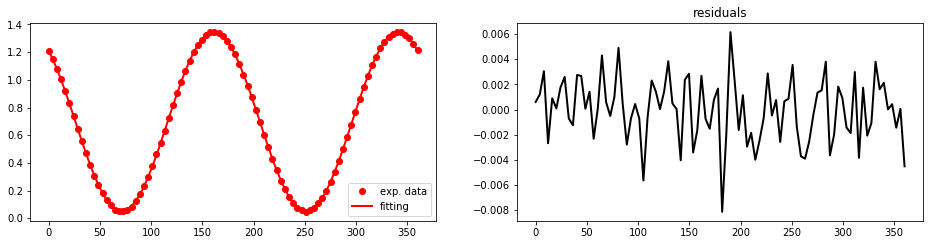

std_residuals=0.00249776544412, = 0.186143092861 %


In [30]:
intensity_numerical=get_intensity_numerical_all(params_all_fin, angles_2, u0)
plot_experiment_residuals_1D(angles_2, intensities_2, intensity_numerical)

residuals2=(intensity_numerical-intensities_2)
print("std_residuals={}, = {} %".format(sp.std(residuals2),
                                        sp.std(residuals2)/intensities_2.max()*100))

## Resultados

In [31]:
# Método 1
Imin=par1[0]-par1[1]
Imax=par1[0]+par1[1]
I0 = 3.1049
angle4_max=par1[3]

if Imin>Imax:
    Imin,Imax=Imax,Imin

print("I0        = {:4.4} V".format(I0))
print("Imin      = {:4.4} V".format(Imin))
print("Imax      = {:4.4} V".format(Imax))
print("angle_max = {:4.5} º".format(angle4_max))

p0=((Imax+sp.sqrt(Imax**2-Imin**2))/I0)**(0.25)
p1=sp.sqrt(Imin/sp.sqrt(I0*(Imax+sp.sqrt(Imax**2-Imin**2))))

if p0>p1:
    p0,p1=p1,p0 
    

I0        = 3.105 V
Imin      = 0.05088 V
Imax      = 1.345 V
angle_max = 2.8117 º


### Comparación

In [32]:
# Metodo 1
print("Polarizer, Method 1 p0={}, p1={}, angulo={}º".format(p0, p1, params_1_fin[0]/degrees-180))

# Método 2
print("Polarizer, Method 2 p0={}, p1={}, angulo={}º".format(params_all_fin[2], params_all_fin[1], params_all_fin[0]/degrees))

# Metodo 1
print("std_residuals 1={}, = {} %".format(sp.std(residuals1),sp.std(residuals1)/intensities_2.max()*100))

# Metodo 2
print("std_residuals={}, = {} %".format(sp.std(residuals2),sp.std(residuals2)/intensities_2.max()*100))


Polarizer, Method 1 p0=0.132707197792, p1=0.964658186799, angulo=22.9275316828º
Polarizer, Method 2 p0=0.128101584361, p1=0.934711947062, angulo=25.6030137077º
std_residuals 1=0.0644309613871, = 4.80164318746 %
std_residuals=0.00249776544412, = 0.186143092861 %


### Conclusión
Me fio más del segundo método